# Moving Average Temperature Service

This is a hybrid service that maintains a moving average of the last N values of the temperature in the incubator. It communicates with the average service to get the average. In addition, as a server, it responds to requests to reset the moving average.

An important feature of this service is that it illustrates how to subscribe to a stream of data coming from the physical twin (or any other service, since it's the same mechanism!).

In [1]:
# Configure python path to load incubator modules
import sys
import os

# Get the current working directory. Should be 1-Incubator-Service
current_dir = os.getcwd()

assert os.path.basename(current_dir) == '1-Incubator-Service', 'Current directory is not 1-Incubator-Service'

# Get the parent directory. Should be the root of the repository
parent_dir = os.path.dirname(current_dir)

# The root of the repo should contain the incubator_dt folder. Otherwise something went wrong in 0-Pre-requisites.
assert os.path.exists(os.path.join(parent_dir, 'incubator_dt')), 'incubator_dt folder not found in the repository root'

incubator_dt_software_dir = os.path.join(parent_dir, 'incubator_dt', 'software')

assert os.path.exists(incubator_dt_software_dir), 'incubator_dt software directory not found'

# Add the parent directory to sys.path
sys.path.append(incubator_dt_software_dir)

In [2]:
# Check that the average_service code is in the current directory
assert os.path.exists(os.path.join(current_dir, 'average_service.py')), 'average_service.py not found in the current directory. Run the previous notebooks in order.'

# Check that logging configuration file is in the current directory
assert os.path.exists(os.path.join(current_dir, 'logging.conf')), 'logging.conf not found in the current directory. Run the previous notebooks in order.'

In [3]:
%%writefile moving_temperature_average_service.py

# Configure python path to load incubator modules
import sys
import os
import logging
import logging.config
import time
from collections import deque

# Get the current working directory. Should be 1-Incubator-Service
current_dir = os.getcwd()

assert os.path.basename(current_dir) == '1-Incubator-Service', 'Current directory is not 1-Incubator-Service'

# Get the parent directory. Should be the root of the repository
parent_dir = os.path.dirname(current_dir)

# The root of the repo should contain the incubator_dt folder. Otherwise something went wrong in 0-Pre-requisites.
assert os.path.exists(os.path.join(parent_dir, 'incubator_dt')), 'incubator_dt folder not found in the repository root'

incubator_dt_software_dir = os.path.join(parent_dir, 'incubator_dt', 'software')

assert os.path.exists(incubator_dt_software_dir), 'incubator_dt software directory not found'

# Add the parent directory to sys.path
sys.path.append(incubator_dt_software_dir)

from incubator.communication.server.rpc_server import RPCServer
from incubator.communication.server.rpc_client import RPCClient
from incubator.communication.shared.protocol import ROUTING_KEY_STATE

class MovingAverageTemperatureService(RPCServer):
    """
    This is a hybrid service that maintains a moving average of the last N values of the temperature in the incubator. It communicates with the average service to get the average. In addition, as a server, it responds to requests to reset the moving average.
    
    """
    def __init__(self, N, rabbitmq_config):
        super().__init__(**rabbitmq_config)

        # Keeps another connection to make RPC calls to the average service
        self._rpc_client = RPCClient(**rabbitmq_config)
        self._values = deque() # keeps a queue of the last N values. Old values are on the left and new ones are on the right.
        self._N = N
        self._l = logging.getLogger("MovingAverageTemperatureService")

    def setup(self):
        """ 
        Setup the RabbitMQ connection and declare the routing_key (this is the topic that this server will listen to) and queue (the name of the queue where all messages addressed to routing_key will be placed in by the RabbitMQ server).

        We use the same name for both the routing_key and the queue name. This is not necessary, but it makes it easier to understand what is happening in the RabbitMQ server.        
        """
        super(MovingAverageTemperatureService, self).setup(routing_key='incubator.dtcourse.moving_temperature_average_service', queue_name='incubator.dtcourse.moving_temperature_average_service')

        # Subscribe to the temperature topic incoming from the incubator physical twin. The ROUTING_KEY_STATE is defined in the protocol module, to avoid typos. It's value should be similar to "incubator.record.driver.state"
        self.subscribe(routing_key=ROUTING_KEY_STATE,
                                on_message_callback=self.process_state_sample)

        self._rpc_client.connect_to_server()

        self._l.info(f"MovingAverageTemperatureService setup complete.")

    def process_state_sample(self, ch, method, properties, body_json):
        """ 
        This is the method that will be invoked by the RPCServer class when a message arrives in the RabbitMQ queue. The body_json is the message that was sent by the incubator physical twin. It should contain the temperature value as well as other sensor values.
        """

        # Log the values received.
        self._l.info(f"Received state sample: {body_json}")

        # Append the temperature value to the deque
        self._values.append(body_json["fields"]["average_temperature"])

        # If the deque is larger than N, pop the oldest element
        if len(self._values) > self._N:
            self._values.popleft()

        # Prepare the message to send to the average service
        arguments = {
            "values": list(self._values)
        }

        # Call the average service to get the average
        response = self._rpc_client.invoke_method("incubator.dtcourse.average_service", "compute_average", arguments)

        # Log the response
        self._l.info(f"average_service response: {response}")

        if "average" in response:
            # Add the average to the body_json
            moving_average = response["average"]
            
            # Prepare a message to publish under a new topic representing this service's data stream. We reuse the same timestamp from the original message, to enable easier traceability between outputs and inputs.
            timestamp = body_json["time"]

            # The format of this message will become later. This is just to allow a uniform way to send data to the database.
            message = {
                "measurement": "moving_temperature_average_service",
                "time": timestamp,
                "tags": {
                    "source": "moving_temperature_average_service"
                },
                "fields": {
                    "moving_average_temperature": moving_average,
                }
            }

            # Log message
            self._l.info(f"Sending message: {message}")

            # Publish the message to the RabbitMQ server
            self.send_message("incubator.record.dtcourse.moving_temperature_average_service.temperature_moving_average", message)
        else:
            self._l.error(f"Error: {response}")


    def reset_average(self, reply_fun):
        """ 
        This is the method that will be invoked by the RPCServer class when a message arrives in the RabbitMQ queue. The reply_fun is a function that we can call to send the results back to the client that sent the message.
        """

         # Log the values received.
        self._l.info(f"reset_average called.")
        
        # Pop all elements except the most recent one
        while len(self._values) > 1:
            self._values.popleft()

        assert len(self._values) == 1 or len(self._values)==0, f"Expected 1 or 0 elements in the deque. Found {len(self._values)} elements."

        success_msg = "Average reset successfully."

        self._l.info(success_msg)

        # Prepare the results to send back.
        result_msg = {
            "msg": success_msg,
        }

        # Send results back.
        reply_fun(result_msg)
    
if __name__ == "__main__":
    # Get utility functions to config logging and load configuration
    from incubator.config.config import load_config
    from pyhocon import ConfigFactory
    
    # Get logging configuration
    logging.config.fileConfig("logging.conf")

    # Get path to the startup.conf file used in the incubator dt:
    startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'incubator_dt', 'software','startup.conf')
    assert os.path.exists(startup_conf), 'startup.conf file not found'

    # The startup.conf comes from the incubator dt repository.
    config = ConfigFactory.parse_file(startup_conf)
    service = MovingAverageTemperatureService(N=10, rabbitmq_config=config["rabbitmq"])

    service.setup()
    
    # Start the MovingAverageTemperatureService
    service.start_serving()

Overwriting moving_temperature_average_service.py


In [ ]:
# You can run this, or you can run the command below in a new terminal windows to start the service
import subprocess
import time

# Start a process asynchronously
avg_service_proc = subprocess.Popen([sys.executable, "average_service.py"])

# Wait for 5 seconds for the process to start
time.sleep(5)

# Print the PID of the process. You can search for this in your task manager to see the process running and kill it if necessary.
print(f"average_service = {avg_service_proc.pid}")

# Check process hasn't crashed
assert avg_service_proc.poll() is None, "Average service process has crashed"

average_service = 25820


In [5]:
# Print contents of log file to verify that the service is running
with open('AverageService.log', 'r') as f:
    print(f.read())

# Check process hasn't crashed
assert avg_service_proc.poll() is None, "Average service process has crashed"

2024-11-06 14:23:08.549 DEBUG AverageService : Connected.
2024-11-06 14:23:08.555 DEBUG AverageService : Ready to listen for msgs in queue incubator.dtcourse.average_service bound to topic incubator.dtcourse.average_service
2024-11-06 14:23:08.555 INFO AverageService : AverageService setup complete.



In [ ]:
# Start a process asynchronously
moving_temperature_average_service_proc = subprocess.Popen([sys.executable, "moving_temperature_average_service.py"])

# Wait for 5 seconds for the process to start
time.sleep(5)

# Print the PID of the process. You can search for this in your task manager to see the process running and kill it if necessary.
print(f"moving_temperature_average_service = {moving_temperature_average_service_proc.pid}")

# Check process hasn't crashed
assert moving_temperature_average_service_proc.poll() is None, "MovingAverageTemperatureService process has crashed"

moving_temperature_average_service = 26960


In [7]:
# Print contents of log file to verify that the service is running
with open('MovingAverageTemperatureService.log', 'r') as f:
    print(f.read())

# Check process hasn't crashed
assert moving_temperature_average_service_proc.poll() is None, "MovingAverageTemperatureService process has crashed"

2024-11-06 14:23:31.888 DEBUG MovingAverageTemperatureService : Connected.
2024-11-06 14:23:31.896 DEBUG MovingAverageTemperatureService : Ready to listen for msgs in queue incubator.dtcourse.moving_temperature_average_service bound to topic incubator.dtcourse.moving_temperature_average_service
2024-11-06 14:23:31.900 INFO MovingAverageTemperatureService : Bound incubator.record.driver.state--> amq.gen-jj0e1JFBI4YDhfXxzfEcNg
2024-11-06 14:23:31.953 INFO MovingAverageTemperatureService : MovingAverageTemperatureService setup complete.
2024-11-06 14:23:32.857 INFO MovingAverageTemperatureService : Received state sample: {'measurement': 'low_level_driver', 'time': 1730899412815169600, 'tags': {'source': 'low_level_driver'}, 'fields': {'t1': 22.323520041549298, 'time_t1': 1730899412814170800, 't2': 28.323520041549298, 'time_t2': 1730899412815169600, 't3': 21.0, 'time_t3': 1730899412815169600, 'average_temperature': 25.323520041549298, 'heater_on': True, 'fan_on': True, 'execution_interval'

Now that both services are running, open the time series database management page (username and password are given in the incubator DT documentation), and explore the data to see the average temperature service output. Create a query as follows:

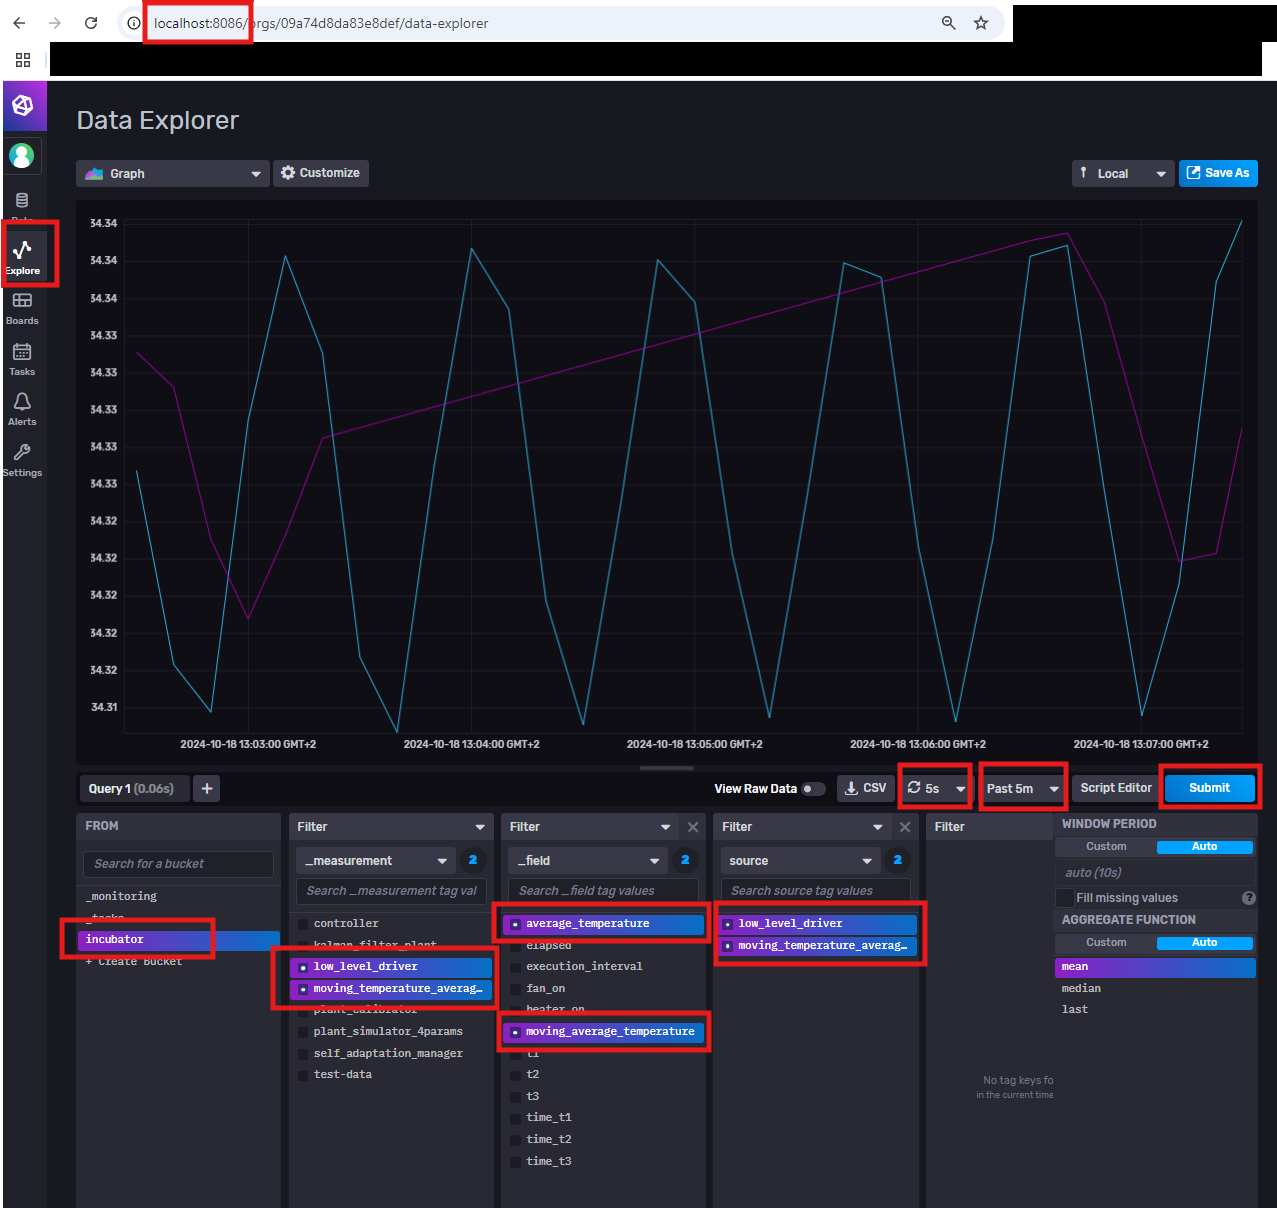

In the results you can see the temperature data stream coming from the physical twin (low_level_driver) and the moving average temperature coming from your new service.

Any message in the format below sent to a topic that is prefixed with `incubator.record.`, will be automatically placed in the time series database. This is done by a DT service.

Data format:
```python
message =   {
                "measurement": "<name of measurement>",
                "time": <timestamp>,
                "tags": {
                    "source": "<source of measurement>"
                },
                "fields": {
                    "Value A Name": value_a,
                    "Value B Name": value_b,
                    ...
                }
            }
```

Now that the service is running let us send a reset average message, to test it.

In [ ]:
# Import RPCClient class from incubator, which makes connecting to RabbitMQ and calling remote methods easy.
from incubator.communication.server.rpc_client import RPCClient
from pyhocon import ConfigFactory

# Get config
startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'incubator_dt', 'software','startup.conf')
config = ConfigFactory.parse_file(startup_conf)

with RPCClient(**(config["rabbitmq"])) as client:
    reply = client.invoke_method("incubator.dtcourse.moving_temperature_average_service", "reset_average", {})
    print(reply)
    assert "msg" in reply
    assert reply["msg"] == "Average reset successfully."

# Check that none of the processes have crashed
assert avg_service_proc.poll() is None, "Average service process has crashed"
assert moving_temperature_average_service_proc.poll() is None, "MovingAverageTemperatureService process has crashed"

{'msg': 'Average reset successfully.'}


In [ ]:
# Print contents of log file to check that the service received the request and sent a response
with open('MovingAverageTemperatureService.log', 'r') as f:
    print(f.read())

# Check that none of the processes have crashed
assert moving_temperature_average_service_proc.poll() is None, "MovingAverageTemperatureService process has crashed"

2024-10-20 15:43:01.171 DEBUG MovingAverageTemperatureService : Connected.
2024-10-20 15:43:01.181 DEBUG MovingAverageTemperatureService : Ready to listen for msgs in queue incubator.dtcourse.moving_temperature_average_service bound to topic incubator.dtcourse.moving_temperature_average_service
2024-10-20 15:43:01.184 INFO MovingAverageTemperatureService : Bound incubator.record.driver.state--> amq.gen-bMjvjTuO127B_McyGwDz3Q
2024-10-20 15:43:01.247 INFO MovingAverageTemperatureService : MovingAverageTemperatureService setup complete.
2024-10-20 15:43:02.711 INFO MovingAverageTemperatureService : Received state sample: {'measurement': 'low_level_driver', 'time': 1729431782661989800, 'tags': {'source': 'low_level_driver'}, 'fields': {'t1': 42.249096576749935, 'time_t1': 1729431782660997300, 't2': 48.249096576749935, 'time_t2': 1729431782661989800, 't3': 21.0, 'time_t3': 1729431782661989800, 'average_temperature': 45.249096576749935, 'heater_on': True, 'fan_on': True, 'execution_interval'

In [10]:
moving_temperature_average_service_proc.terminate() # Terminate the process. Send SIGTERM signal to the process. The process can catch this signal and perform cleanup operations before exiting, so we wait.
moving_temperature_average_service_proc.wait()  # Wait for the process to exit fully. Should print exit code 1, due to interruption.

# Ensure process has exited
assert moving_temperature_average_service_proc.returncode is not None, 'Process has not exited'

In [11]:
avg_service_proc.terminate() # Terminate the process. Send SIGTERM signal to the process. The process can catch this signal and perform cleanup operations before exiting, so we wait.
avg_service_proc.wait()  # Wait for the process to exit fully. Should print exit code 1, due to interruption.

# Ensure process has exited
assert avg_service_proc.returncode is not None, 'Process has not exited'

## Exercises

1. Update the moving average service to also output the moving standard error (using the value computed by the average service you modified in the previous exercises). The new message output should look like:
    ```python
    message = {
                "measurement": "moving_temperature_average_service",
                "time": timestamp,
                "tags": {
                    "source": "moving_temperature_average_service"
                },
                "fields": {
                    "moving_average_temperature": moving_average,
                    "moving_std_error": moving_std_error,
                }
            }
    ```